In [47]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np
import libpysal as lps
import seaborn as sns
import libpysal as lps
import pysal as ps
from libpysal.weights import Queen, Rook, KNN
from shapely import wkt
from scipy.spatial import cKDTree
import sklearn.model_selection as model_select
from math import sqrt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from libpysal import weights
try:
    from scipy.optimize import minimize_scalar
    minimize_scalar_available = True
except ImportError:
    minimize_scalar_available = False
import warnings
warnings.simplefilter('ignore')

In [48]:
lignocellulose=pd.read_csv("dataset/protein/Lignocellulose.csv")

In [49]:
lignocellulose.columns

Index(['Country Code', 'Barley_Cellulose_2030', 'Barley_Hemicellulose_2030',
       'Barley_Lignin_2030', 'Barley_Cellulose_2040',
       'Barley_Hemicellulose_2040', 'Barley_Lignin_2040',
       'Maize_Cellulose_2030', 'Maize_Hemicellulose_2030', 'Maize_Lignin_2030',
       'Maize_Cellulose_2040', 'Maize_Hemicellulose_2040', 'Maize_Lignin_2040',
       'Rice_Cellulose_2030', 'Rice_Hemicellulose_2030', 'Rice_Lignin_2030',
       'Rice_Cellulose_2040', 'Rice_Hemicellulose_2040', 'Rice_Lignin_2040',
       'Sorghum_Cellulose_2030', 'Sorghum_Hemicellulose_2030',
       'Sorghum_Lignin_2030', 'Sorghum_Cellulose_2040',
       'Sorghum_Hemicellulose_2040', 'Sorghum_Lignin_2040',
       'Wheat_Cellulose_2030', 'Wheat_Hemicellulose_2030', 'Wheat_Lignin_2030',
       'Wheat_Cellulose_2040', 'Wheat_Hemicellulose_2040', 'Wheat_Lignin_2040',
       'Protein-2030', 'Protein-2040'],
      dtype='object')

In [50]:
lignocellulose.head()

Country Code  Barley_Cellulose_2030  Barley_Hemicellulose_2030  \
0             2           9.554176e+05               4.893602e+05   
1             3           1.787305e+07               9.154491e+06   
2             4           8.942505e+05               4.580307e+05   
3             5           3.405707e+07               1.744387e+07   
4             6           8.897761e+06               4.557390e+06   

   Barley_Lignin_2030  Barley_Cellulose_2040  Barley_Hemicellulose_2040  \
0        8.156004e+05           9.554176e+05               4.893602e+05   
1        1.525749e+07           1.787305e+07               9.154491e+06   
2        7.633846e+05           8.942505e+05               4.580307e+05   
3        2.907311e+07           3.405707e+07               1.744387e+07   
4        7.595650e+06           8.897761e+06               4.557390e+06   

   Barley_Lignin_2040  Maize_Cellulose_2030  Maize_Hemicellulose_2030  \
0        8.156004e+05          4.504484e+06              3.118489e+06   
1        1.525749e+07          9.686418e+05              6.705982e+05   
2        7.633846e+05          5.690978e+06              3.939908e+06   
3        2.907311e+07          1.136660e+06              7.869185e+05   
4        7.595650e+06          2.368128e+06              1.639474e+06   

   Maize_Lignin_2030  ...  Sorghum_Hemicellulose_2040  Sorghum_Lignin_2040  \
0       3.811487e+06  ...                 249039.2325          1514988.664   
1       8.196200e+05  ...                 142115.9604           864538.759   
2       4.815443e+06  ...                 272172.8387          1655718.102   
3       9.617893e+05  ...                 367318.6817          2234521.980   
4       2.003801e+06  ...                 200752.0747          1221241.788   

   Wheat_Cellulose_2030  Wheat_Hemicellulose_2030  Wheat_Lignin_2030  \
0          1.389113e+07              9.870012e+06       1.316002e+07   
1          8.501577e+05              6.040594e+05       8.054126e+05   
2          1.339335e+07              9.516328e+06       1.268844e+07   
3          3.571498e+06              2.537643e+06       3.383524e+06   
4          3.581540e+06              2.544778e+06       3.393037e+06   

   Wheat_Cellulose_2040  Wheat_Hemicellulose_2040  Wheat_Lignin_2040  \
0          1.389113e+07              9.870012e+06       1.316002e+07   
1          8.501577e+05              6.040594e+05       8.054126e+05   
2          1.339335e+07              9.516328e+06       1.268844e+07   
3          3.571498e+06              2.537643e+06       3.383524e+06   
4          3.581540e+06              2.544778e+06       3.393037e+06   

   Protein-2030  Protein-2040  
0  9.954830e+06   10081737.88  
1  7.498345e+06    9923329.83  
2  9.976966e+06   10095554.60  
3  1.385455e+07   18483281.12  
4  6.122656e+06    7327000.82  

[5 rows x 33 columns]

In [51]:
#read country code
country_code=pd.read_csv("dataset/country_data.csv",usecols=["Country Code","Country","ISO2 Code","ISO3 Code"])
country_code.head()

Country Code         Country ISO2 Code ISO3 Code
0             2     Afghanistan        AF       AFG
1          5100          Africa       NaN       X06
2             3         Albania        AL       ALB
3             4         Algeria        DZ       DZA
4             5  American Samoa        AS       ASM

In [52]:
#read shapefile
poly=gpd.read_file("dataset/wb_countries_admin0_10m/wb_countries_admin0_10m.shp")
poly.columns

Index(['OBJECTID', 'featurecla', 'LEVEL', 'TYPE', 'FORMAL_EN', 'FORMAL_FR',
       'POP_EST', 'POP_RANK', 'GDP_MD_EST', 'POP_YEAR', 'LASTCENSUS',
       'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10_', 'ISO_A2', 'ISO_A3',
       'ISO_A3_EH', 'ISO_N3', 'UN_A3', 'WB_A2', 'WB_A3', 'CONTINENT',
       'REGION_UN', 'SUBREGION', 'REGION_WB', 'NAME_AR', 'NAME_BN', 'NAME_DE',
       'NAME_EN', 'NAME_ES', 'NAME_FR', 'NAME_EL', 'NAME_HI', 'NAME_HU',
       'NAME_ID', 'NAME_IT', 'NAME_JA', 'NAME_KO', 'NAME_NL', 'NAME_PL',
       'NAME_PT', 'NAME_RU', 'NAME_SV', 'NAME_TR', 'NAME_VI', 'NAME_ZH',
       'WB_NAME', 'WB_RULES', 'WB_REGION', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

In [53]:
poly.loc[50,"ISO_A3_EH"]="NOR"

In [54]:
#merge country code and shapefile
country_poly=pd.merge(country_code,poly,left_on="ISO3 Code",right_on="ISO_A3_EH",how="inner")
country_poly.head()

Country Code         Country ISO2 Code ISO3 Code  OBJECTID  \
0             2     Afghanistan        AF       AFG       126   
1             3         Albania        AL       ALB        61   
2             4         Algeria        DZ       DZA       118   
3             5  American Samoa        AS       ASM       228   
4             6         Andorra        AD       AND       125   

        featurecla  LEVEL               TYPE  \
0  Admin-0 country      2  Sovereign country   
1  Admin-0 country      2  Sovereign country   
2  Admin-0 country      2  Sovereign country   
3  Admin-0 country      2         Dependency   
4  Admin-0 country      2  Sovereign country   

                                 FORMAL_EN FORMAL_FR  ...            NAME_SV  \
0             Islamic State of Afghanistan      None  ...        Afghanistan   
1                      Republic of Albania      None  ...           Albanien   
2  People's Democratic Republic of Algeria      None  ...           Algeriet   
3                           American Samoa      None  ...  Amerikanska Samoa   
4                  Principality of Andorra      None  ...            Andorra   

            NAME_TR         NAME_VI  NAME_ZH              WB_NAME  \
0        Afganistan     Afghanistan      阿富汗          Afghanistan   
1        Arnavutluk         Albania    阿尔巴尼亚              Albania   
2           Cezayir         Algérie    阿尔及利亚              Algeria   
3  Amerikan Samoası  Samoa thuộc Mỹ    美屬薩摩亞  American Samoa (US)   
4           Andorra         Andorra      安道尔              Andorra   

         WB_RULES WB_REGION Shape_Leng  Shape_Area  \
0            None       SOA  52.765827   62.591664   
1            None       ECA  11.050457    3.039395   
2            None      MENA  71.641687  212.690941   
3  Name in italic     Other   1.073705    0.015101   
4            None     Other   1.057953    0.049561   

                                            geometry  
0  POLYGON ((74.54235 37.02167, 74.54742 37.01567...  
1  POLYGON ((20.56715 41.87318, 20.54172 41.86158...  
2  POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...  
3  MULTIPOLYGON (((-170.59101 -14.26483, -170.576...  
4  POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...  

[5 rows x 57 columns]

In [55]:
lignocellulose_p=pd.merge(country_poly,lignocellulose,on="Country Code",how="inner")
lignocellulose_p.head()

Country Code         Country ISO2 Code ISO3 Code  OBJECTID  \
0             2     Afghanistan        AF       AFG       126   
1             3         Albania        AL       ALB        61   
2             4         Algeria        DZ       DZA       118   
3             5  American Samoa        AS       ASM       228   
4             6         Andorra        AD       AND       125   

        featurecla  LEVEL               TYPE  \
0  Admin-0 country      2  Sovereign country   
1  Admin-0 country      2  Sovereign country   
2  Admin-0 country      2  Sovereign country   
3  Admin-0 country      2         Dependency   
4  Admin-0 country      2  Sovereign country   

                                 FORMAL_EN FORMAL_FR  ...  \
0             Islamic State of Afghanistan      None  ...   
1                      Republic of Albania      None  ...   
2  People's Democratic Republic of Algeria      None  ...   
3                           American Samoa      None  ...   
4                  Principality of Andorra      None  ...   

   Sorghum_Hemicellulose_2040  Sorghum_Lignin_2040  Wheat_Cellulose_2030  \
0                 249039.2325          1514988.664          1.389113e+07   
1                 142115.9604           864538.759          8.501577e+05   
2                 272172.8387          1655718.102          1.339335e+07   
3                 367318.6817          2234521.980          3.571498e+06   
4                 200752.0747          1221241.788          3.581540e+06   

   Wheat_Hemicellulose_2030  Wheat_Lignin_2030  Wheat_Cellulose_2040  \
0              9.870012e+06       1.316002e+07          1.389113e+07   
1              6.040594e+05       8.054126e+05          8.501577e+05   
2              9.516328e+06       1.268844e+07          1.339335e+07   
3              2.537643e+06       3.383524e+06          3.571498e+06   
4              2.544778e+06       3.393037e+06          3.581540e+06   

  Wheat_Hemicellulose_2040 Wheat_Lignin_2040  Protein-2030 Protein-2040  
0             9.870012e+06      1.316002e+07  9.954830e+06  10081737.88  
1             6.040594e+05      8.054126e+05  7.498345e+06   9923329.83  
2             9.516328e+06      1.268844e+07  9.976966e+06  10095554.60  
3             2.537643e+06      3.383524e+06  1.385455e+07  18483281.12  
4             2.544778e+06      3.393037e+06  6.122656e+06   7327000.82  

[5 rows x 89 columns]

In [60]:
#select columns
lignocellulose_p1=pd.DataFrame(lignocellulose_p,columns=['Country Code', 'Barley_Cellulose_2030', 'Barley_Hemicellulose_2030',
       'Barley_Lignin_2030', 'Barley_Cellulose_2040',
       'Barley_Hemicellulose_2040', 'Barley_Lignin_2040',
       'Maize_Cellulose_2030', 'Maize_Hemicellulose_2030', 'Maize_Lignin_2030',
       'Maize_Cellulose_2040', 'Maize_Hemicellulose_2040', 'Maize_Lignin_2040',
       'Rice_Cellulose_2030', 'Rice_Hemicellulose_2030', 'Rice_Lignin_2030',
       'Rice_Cellulose_2040', 'Rice_Hemicellulose_2040', 'Rice_Lignin_2040',
       'Sorghum_Cellulose_2030', 'Sorghum_Hemicellulose_2030',
       'Sorghum_Lignin_2030', 'Sorghum_Cellulose_2040',
       'Sorghum_Hemicellulose_2040', 'Sorghum_Lignin_2040',
       'Wheat_Cellulose_2030', 'Wheat_Hemicellulose_2030', 'Wheat_Lignin_2030',
       'Wheat_Cellulose_2040', 'Wheat_Hemicellulose_2040',
       'Wheat_Lignin_2040',"Protein-2030","Protein-2040","geometry"] )
lignocellulose_p1=gpd.GeoDataFrame(lignocellulose_p1)
lignocellulose_p1.head()

Country Code  Barley_Cellulose_2030  Barley_Hemicellulose_2030  \
0             2           9.554176e+05               4.893602e+05   
1             3           1.787305e+07               9.154491e+06   
2             4           8.942505e+05               4.580307e+05   
3             5           3.405707e+07               1.744387e+07   
4             6           8.897761e+06               4.557390e+06   

   Barley_Lignin_2030  Barley_Cellulose_2040  Barley_Hemicellulose_2040  \
0        8.156004e+05           9.554176e+05               4.893602e+05   
1        1.525749e+07           1.787305e+07               9.154491e+06   
2        7.633846e+05           8.942505e+05               4.580307e+05   
3        2.907311e+07           3.405707e+07               1.744387e+07   
4        7.595650e+06           8.897761e+06               4.557390e+06   

   Barley_Lignin_2040  Maize_Cellulose_2030  Maize_Hemicellulose_2030  \
0        8.156004e+05          4.504484e+06              3.118489e+06   
1        1.525749e+07          9.686418e+05              6.705982e+05   
2        7.633846e+05          5.690978e+06              3.939908e+06   
3        2.907311e+07          1.136660e+06              7.869185e+05   
4        7.595650e+06          2.368128e+06              1.639474e+06   

   Maize_Lignin_2030  ...  Sorghum_Lignin_2040  Wheat_Cellulose_2030  \
0       3.811487e+06  ...          1514988.664          1.389113e+07   
1       8.196200e+05  ...           864538.759          8.501577e+05   
2       4.815443e+06  ...          1655718.102          1.339335e+07   
3       9.617893e+05  ...          2234521.980          3.571498e+06   
4       2.003801e+06  ...          1221241.788          3.581540e+06   

   Wheat_Hemicellulose_2030  Wheat_Lignin_2030  Wheat_Cellulose_2040  \
0              9.870012e+06       1.316002e+07          1.389113e+07   
1              6.040594e+05       8.054126e+05          8.501577e+05   
2              9.516328e+06       1.268844e+07          1.339335e+07   
3              2.537643e+06       3.383524e+06          3.571498e+06   
4              2.544778e+06       3.393037e+06          3.581540e+06   

   Wheat_Hemicellulose_2040  Wheat_Lignin_2040  Protein-2030  Protein-2040  \
0              9.870012e+06       1.316002e+07  9.954830e+06   10081737.88   
1              6.040594e+05       8.054126e+05  7.498345e+06    9923329.83   
2              9.516328e+06       1.268844e+07  9.976966e+06   10095554.60   
3              2.537643e+06       3.383524e+06  1.385455e+07   18483281.12   
4              2.544778e+06       3.393037e+06  6.122656e+06    7327000.82   

                                            geometry  
0  POLYGON ((74.54235 37.02167, 74.54742 37.01567...  
1  POLYGON ((20.56715 41.87318, 20.54172 41.86158...  
2  POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...  
3  MULTIPOLYGON (((-170.59101 -14.26483, -170.576...  
4  POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...  

[5 rows x 34 columns]

Text(0.5, 1, 'Cellulose of Maize in 2040 (tonnes)')

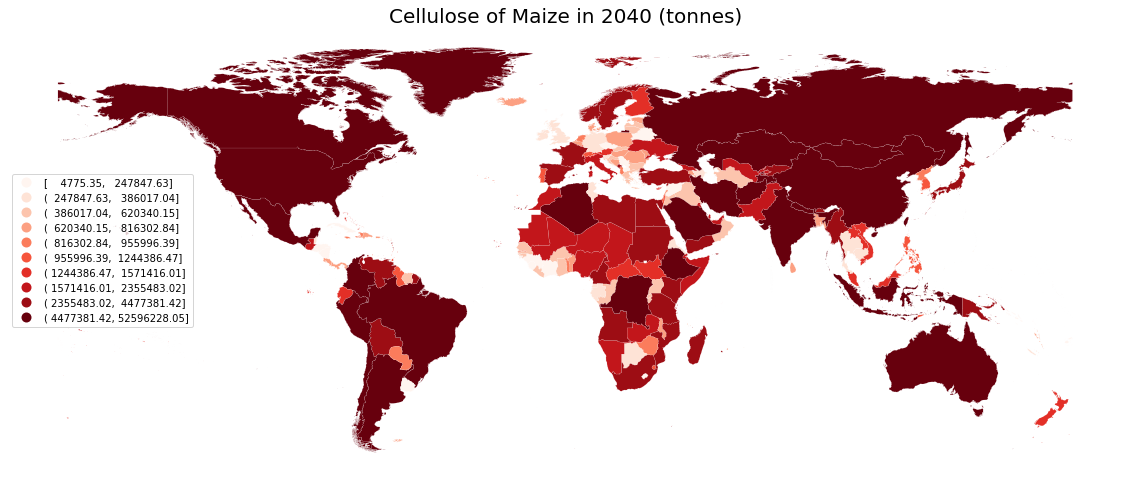

In [61]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Maize_Cellulose_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Cellulose of Maize in 2040 (tonnes)", fontsize=20)

Text(0.5, 1, 'Cellulose of Rice in 2040 (tonnes)')

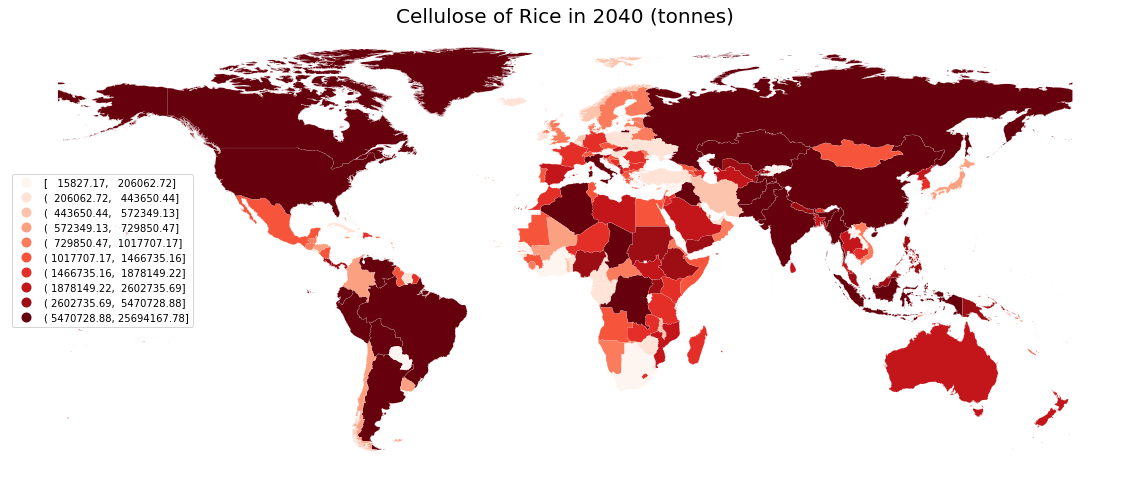

In [62]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Rice_Cellulose_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Cellulose of Rice in 2040 (tonnes)", fontsize=20)

Text(0.5, 1, 'Cellulose of Wheat in 2040 (tonnes)')

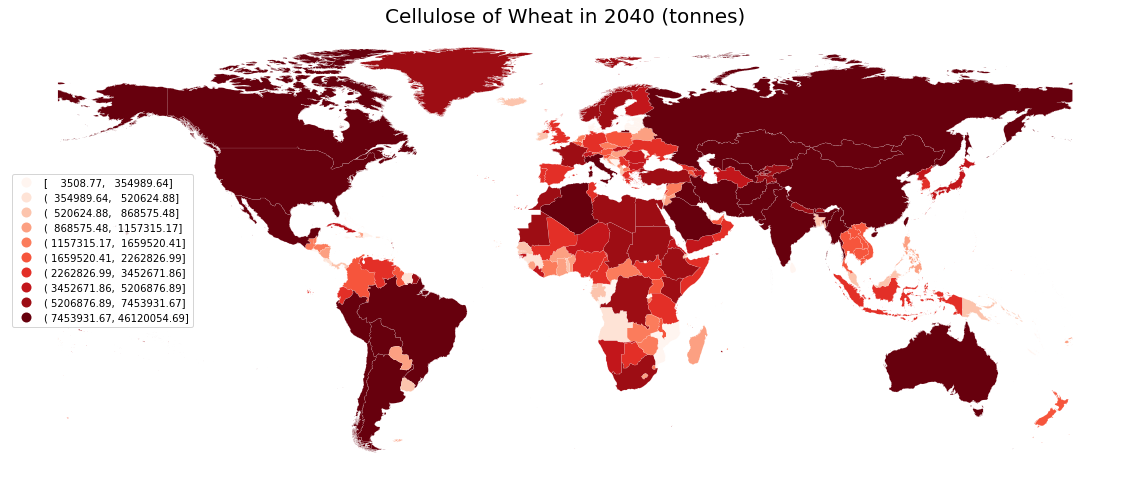

In [63]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Wheat_Cellulose_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Cellulose of Wheat in 2040 (tonnes)", fontsize=20)

Text(0.5, 1, 'Cellulose of Barley in 2040 (tonnes)')

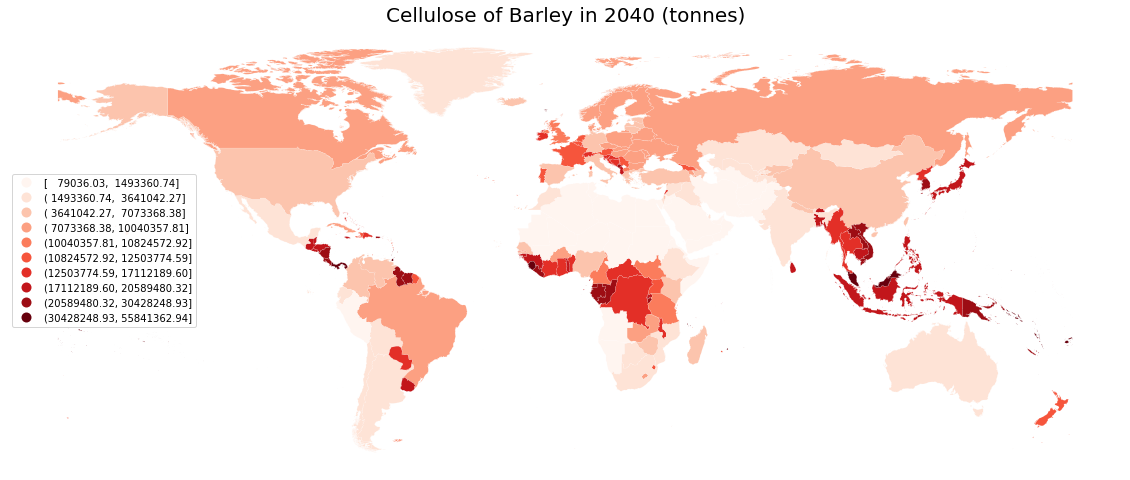

In [64]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Barley_Cellulose_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Cellulose of Barley in 2040 (tonnes)", fontsize=20)

Text(0.5, 1, 'Cellulose of Sorghum in 2040 (tonnes)')

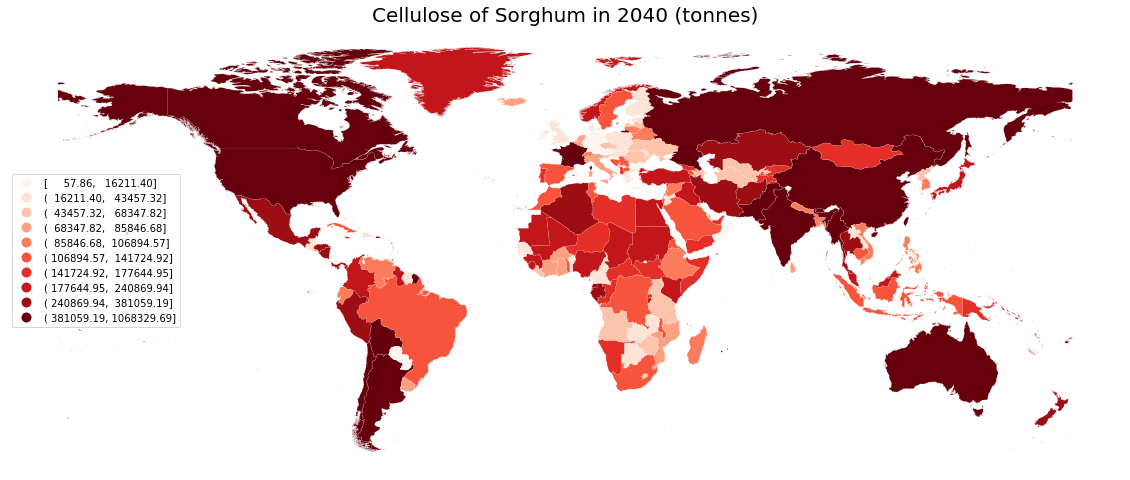

In [65]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Sorghum_Cellulose_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Cellulose of Sorghum in 2040 (tonnes)", fontsize=20)

Text(0.5, 1, 'New Protein (SCP) in 2030 (tonnes)')

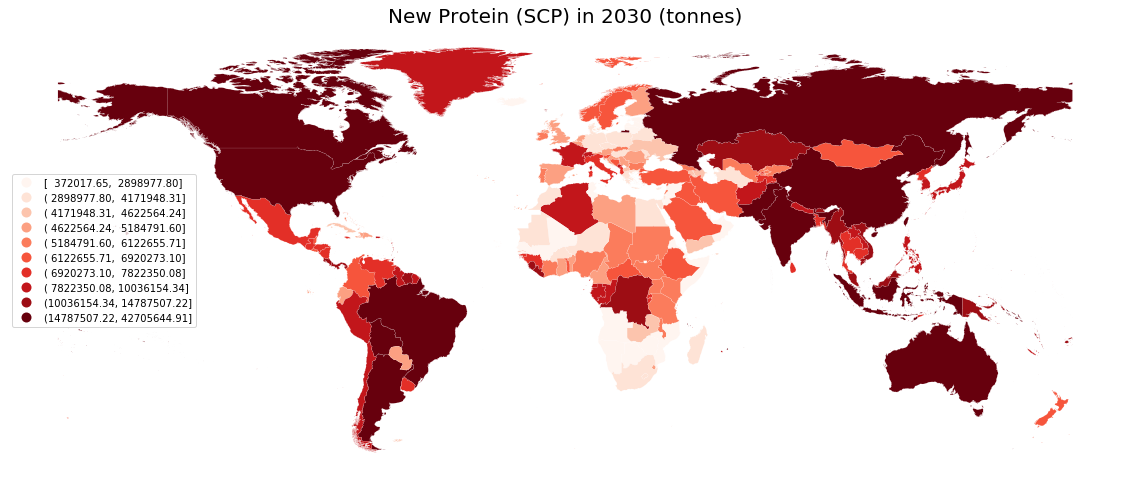

In [67]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Protein-2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("New Protein (SCP) in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'New Protein (SCP) in 2040 (tonnes)')

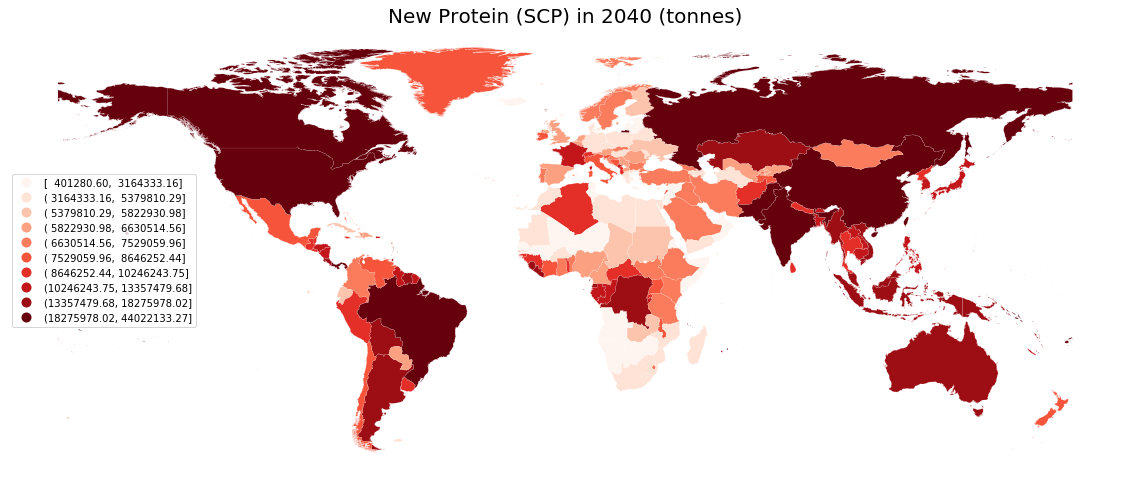

In [68]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Protein-2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("New Protein (SCP) in 2040 (tonnes)", fontsize=20)

Text(0.5, 1, 'Cellulose of Maize in 2030 (tonnes)')

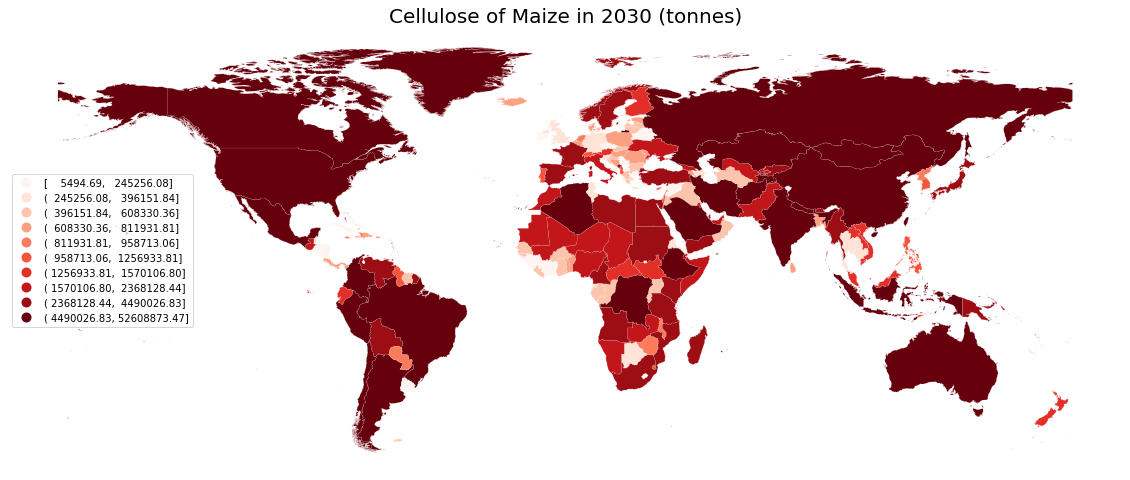

In [70]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Maize_Cellulose_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Cellulose of Maize in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'Lignin of Maize in 2030 (tonnes)')

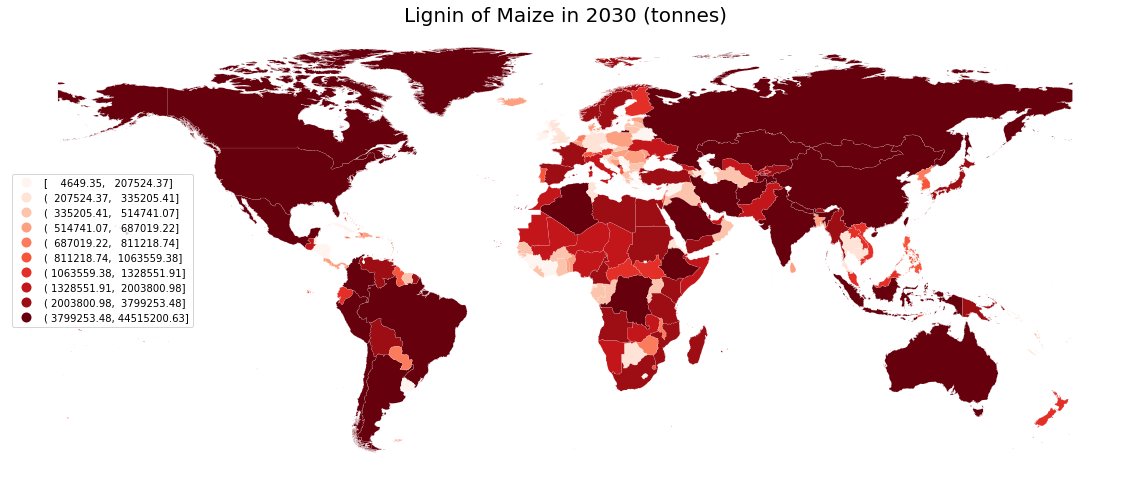

In [72]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Maize_Lignin_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Lignin of Maize in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'Lignin of Maize in 2040 (tonnes)')

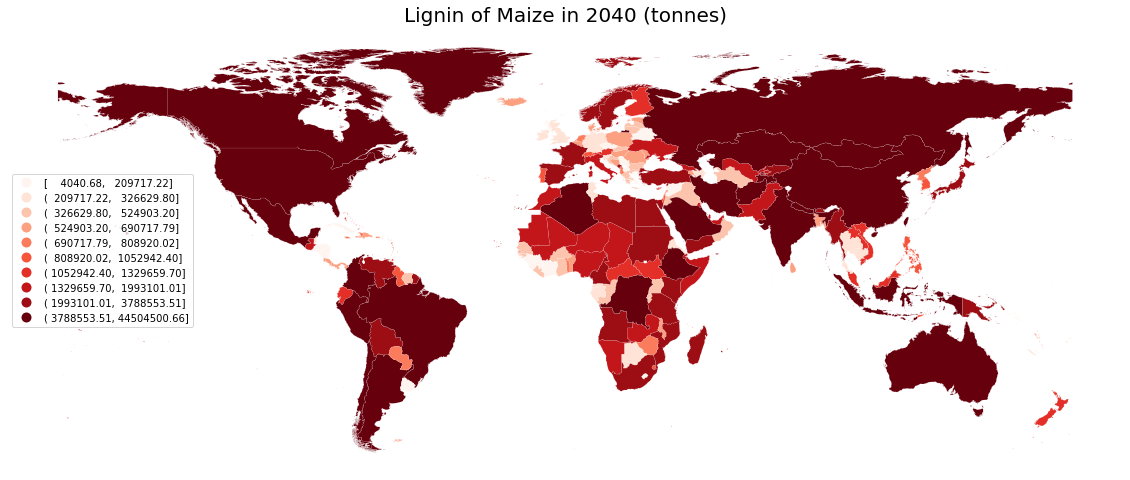

In [73]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Maize_Lignin_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Lignin of Maize in 2040 (tonnes)", fontsize=20)

Text(0.5, 1, 'Hemicellulose of Maize in 2030 (tonnes)')

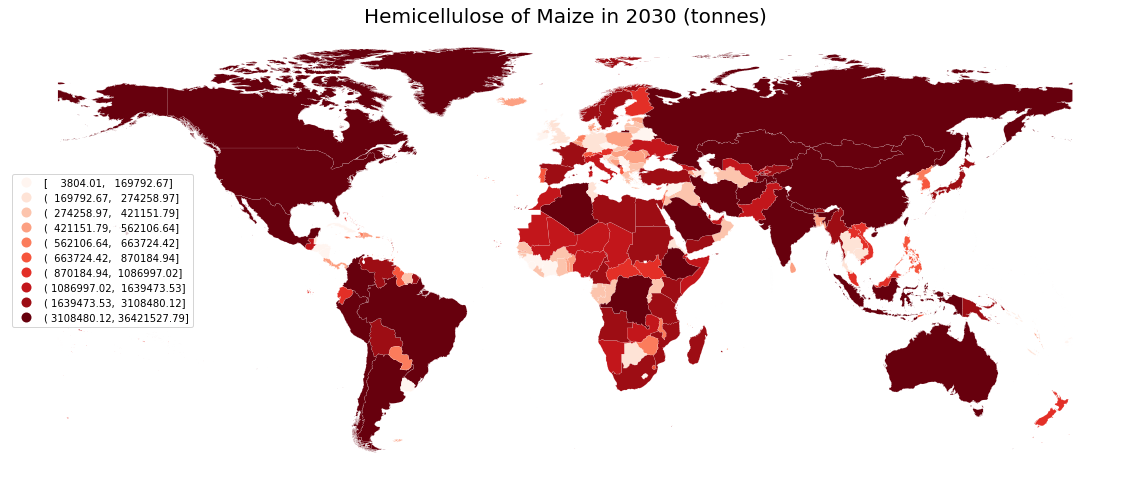

In [74]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Maize_Hemicellulose_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Hemicellulose of Maize in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'Hemicellulose of Maize in 2040 (tonnes)')

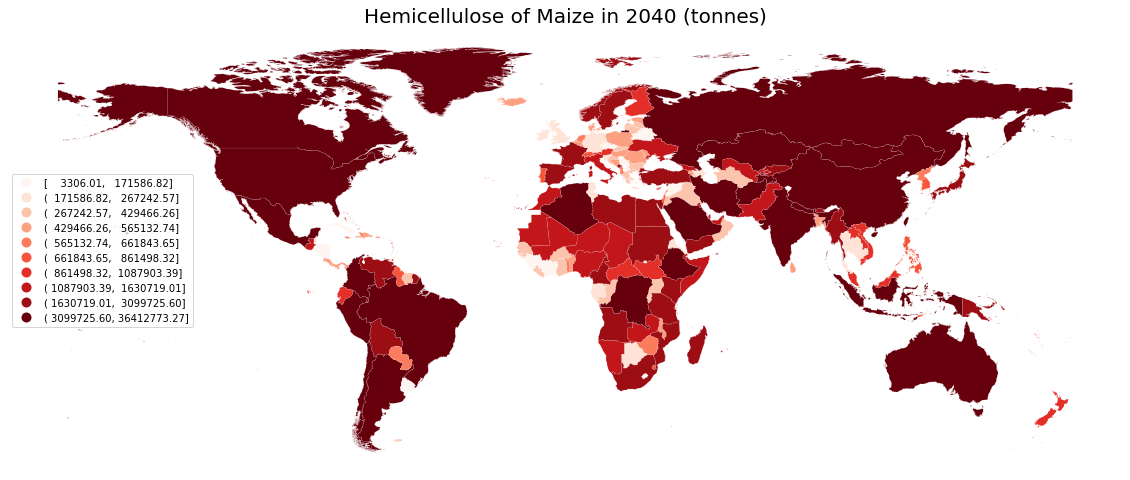

In [75]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Maize_Hemicellulose_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Hemicellulose of Maize in 2040 (tonnes)", fontsize=20)

Text(0.5, 1, 'Cellulose of Barley in 2030 (tonnes)')

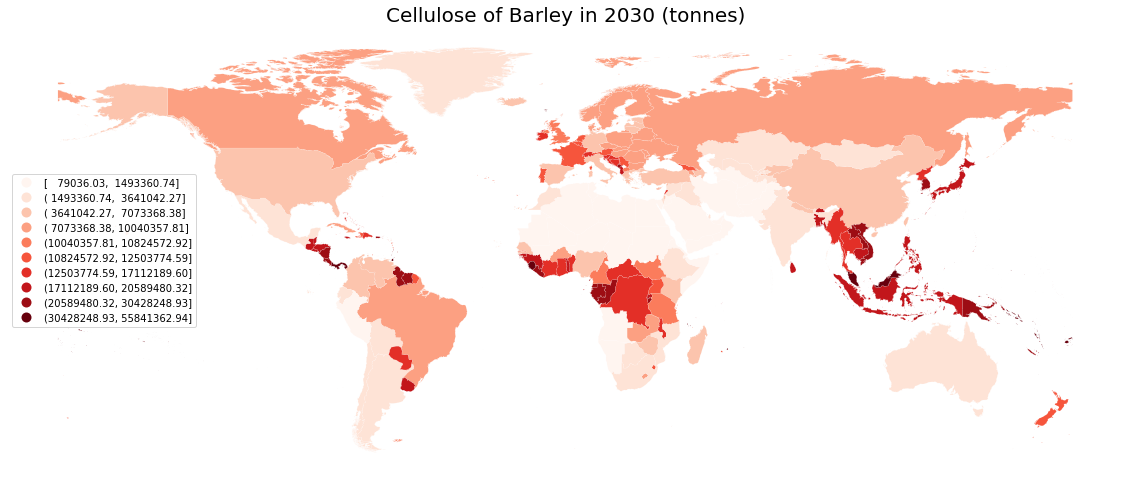

In [76]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Barley_Cellulose_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Cellulose of Barley in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'Lignin of Barley in 2030 (tonnes)')

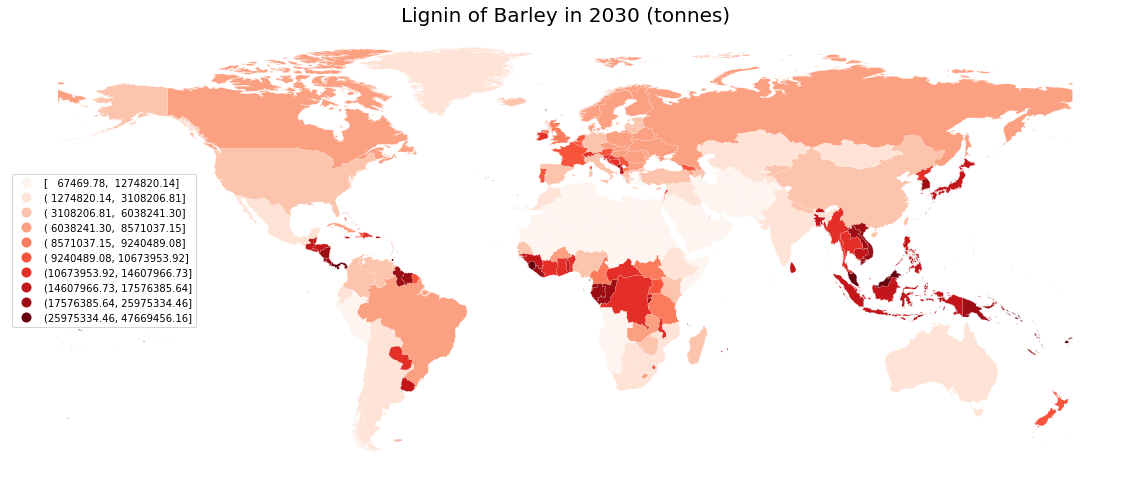

In [77]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Barley_Lignin_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Lignin of Barley in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'Lignin of Barley in 2040 (tonnes)')

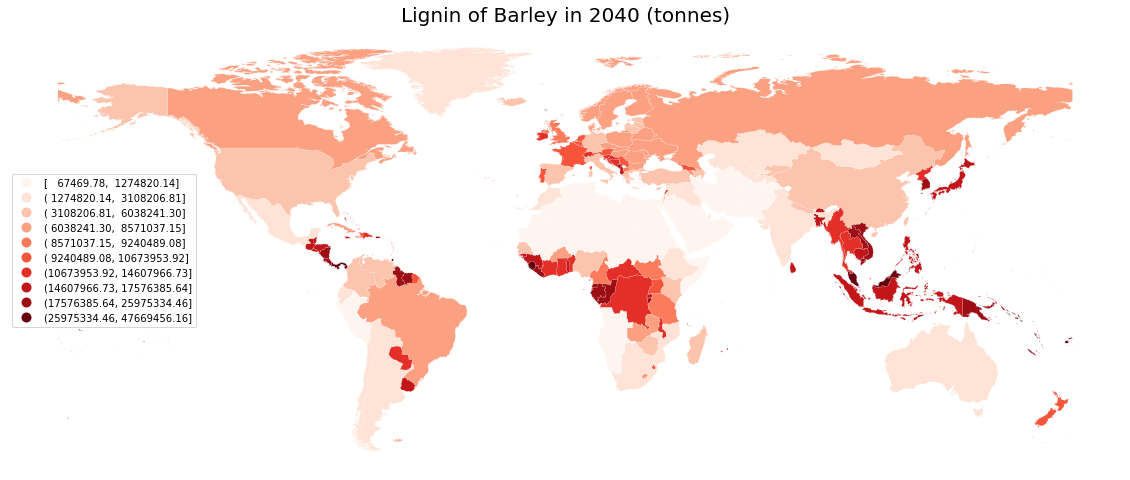

In [78]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Barley_Lignin_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Lignin of Barley in 2040 (tonnes)", fontsize=20)

Text(0.5, 1, 'Hemicellulose of Barley in 2030 (tonnes)')

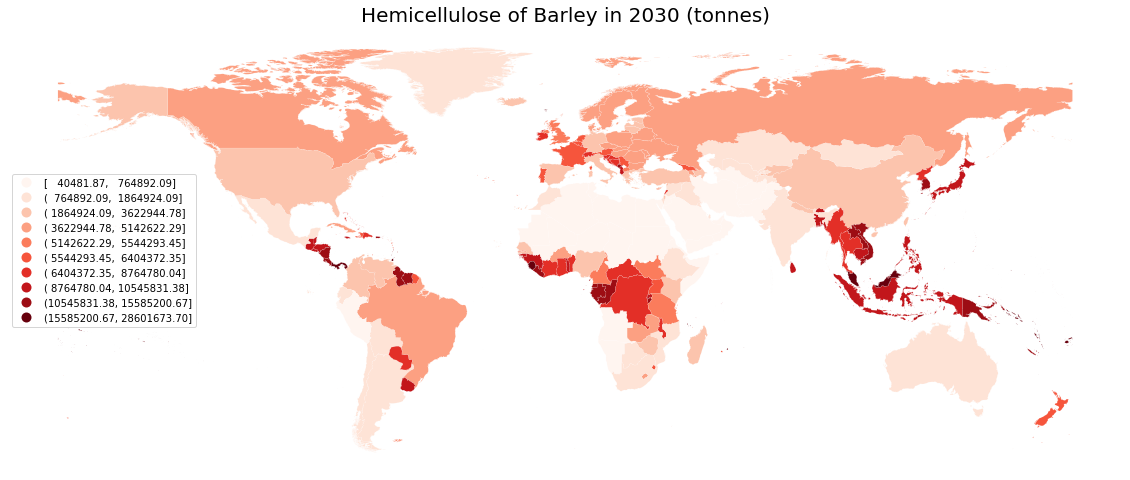

In [79]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Barley_Hemicellulose_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Hemicellulose of Barley in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'Hemicellulose of Barley in 2040 (tonnes)')

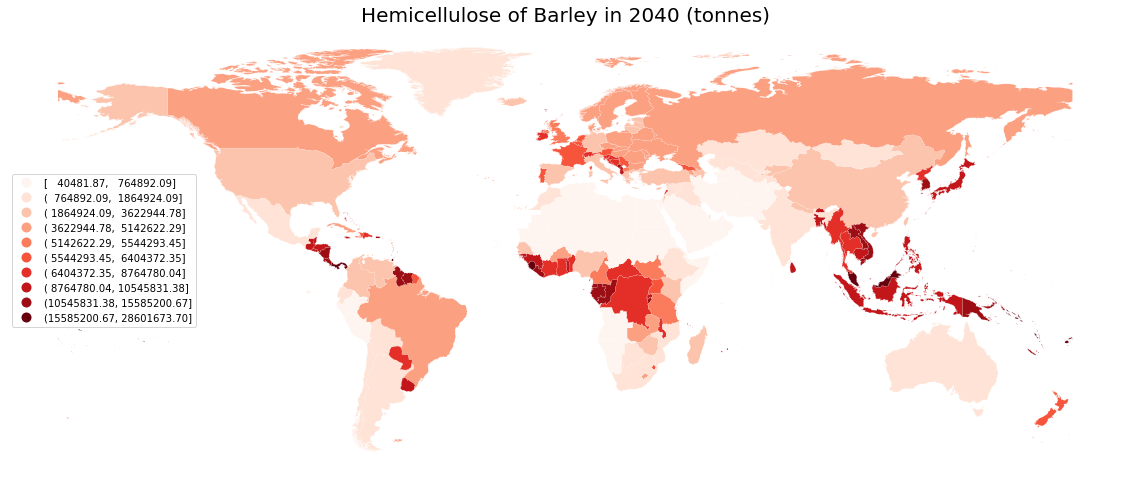

In [80]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Barley_Hemicellulose_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Hemicellulose of Barley in 2040 (tonnes)", fontsize=20)

Text(0.5, 1, 'Cellulose of Rice in 2030 (tonnes)')

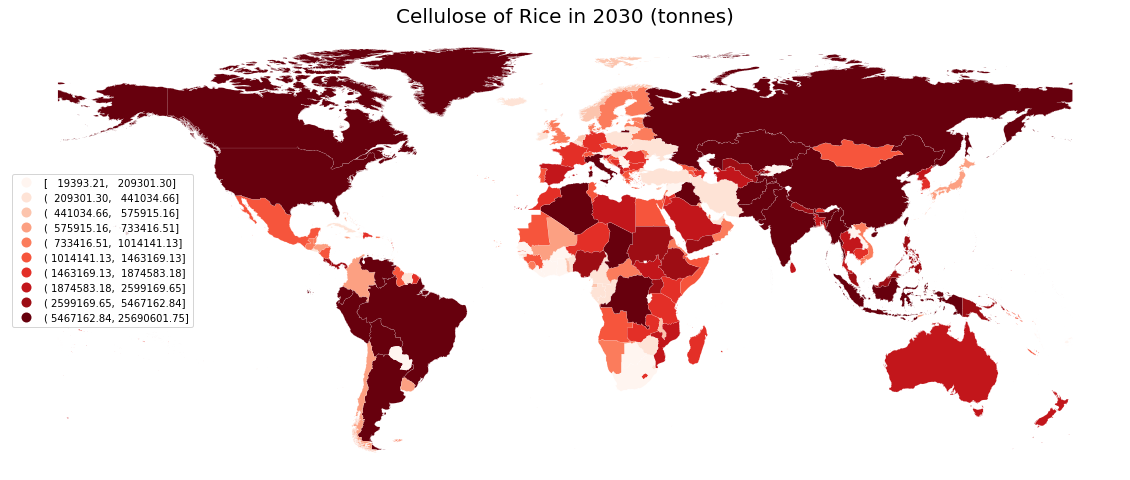

In [81]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Rice_Cellulose_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Cellulose of Rice in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'Lignin of Rice in 2030 (tonnes)')

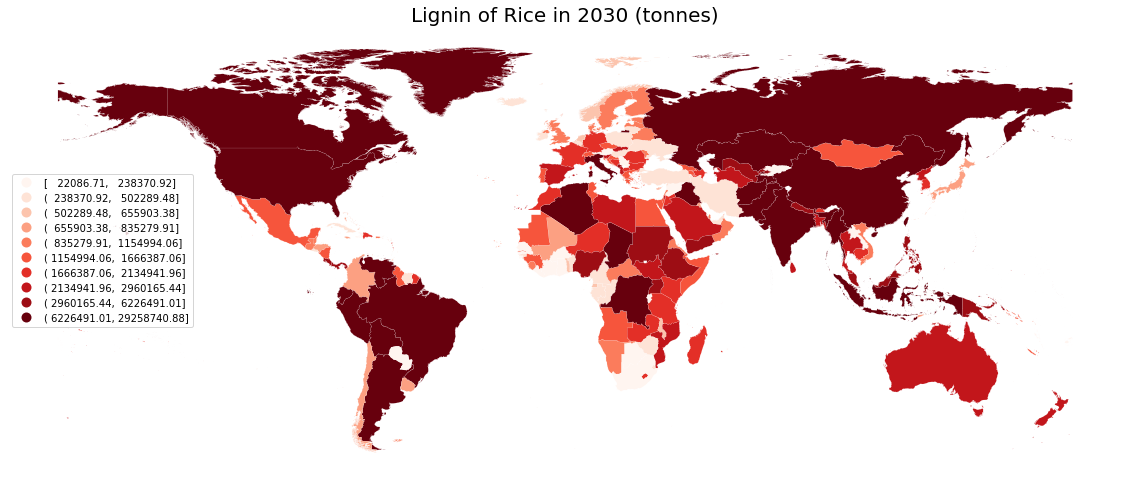

In [82]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Rice_Lignin_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Lignin of Rice in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'Lignin of Rice in 2040 (tonnes)')

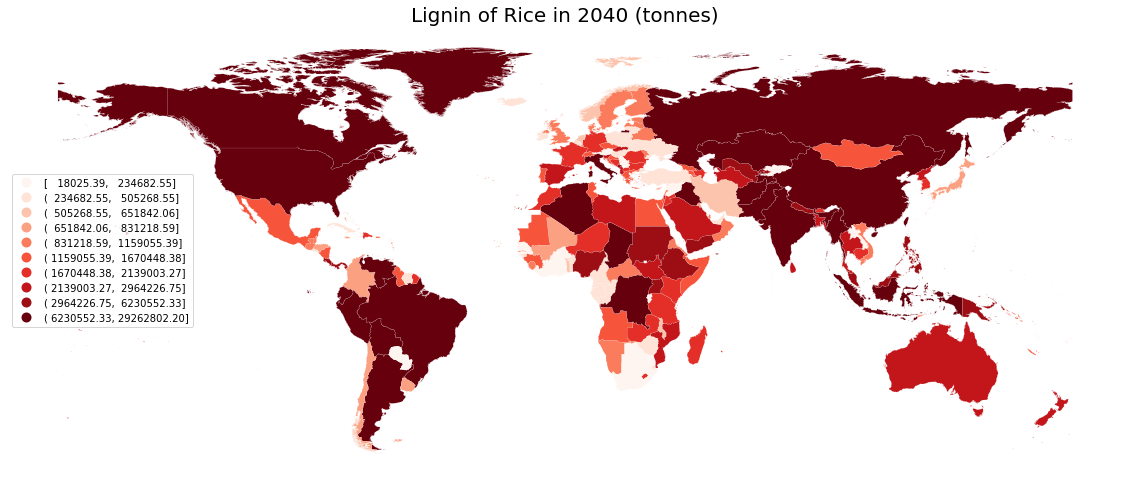

In [83]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Rice_Lignin_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Lignin of Rice in 2040 (tonnes)", fontsize=20)

Text(0.5, 1, 'Hemicellulose of Rice in 2030 (tonnes)')

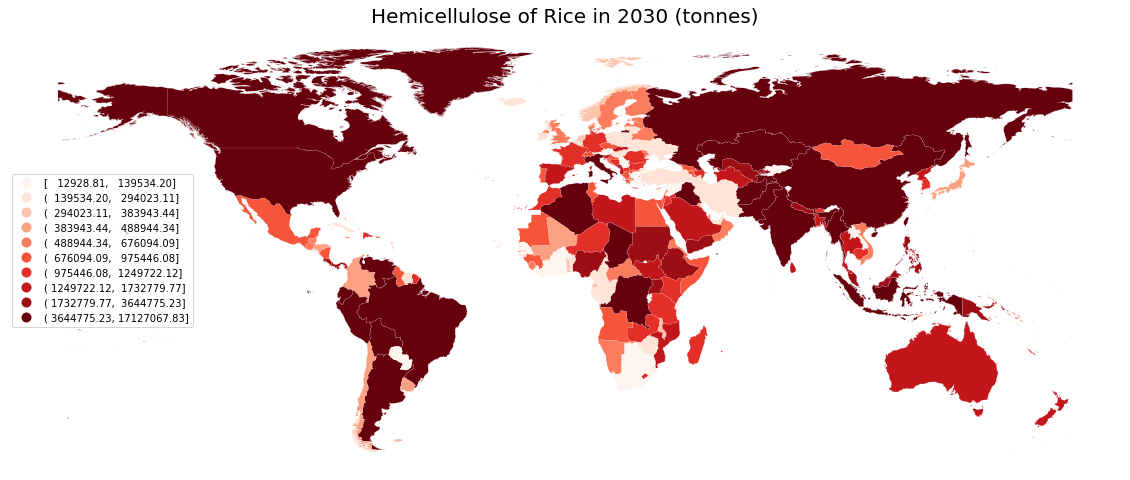

In [84]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Rice_Hemicellulose_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Hemicellulose of Rice in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'Hemicellulose of Rice in 2040 (tonnes)')

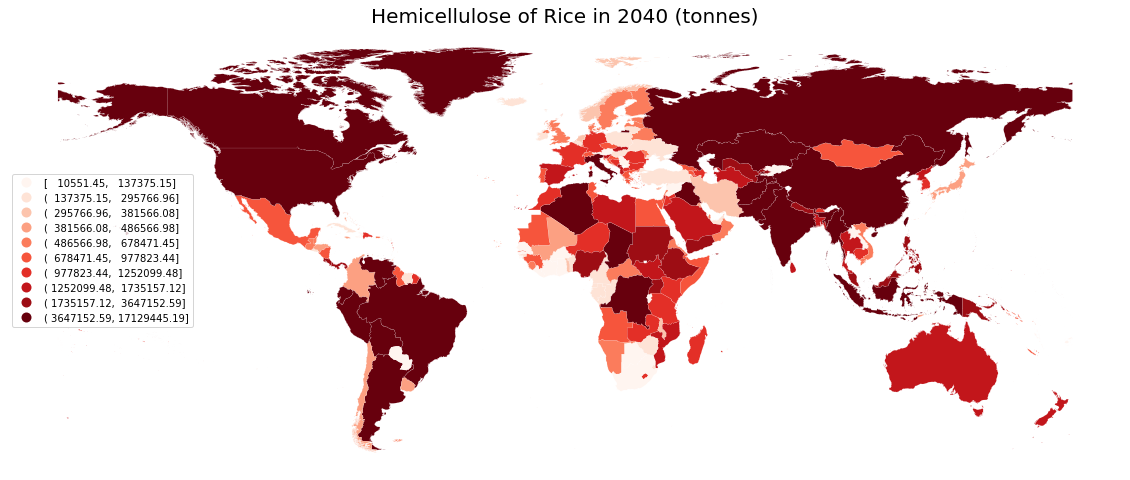

In [85]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Rice_Hemicellulose_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Hemicellulose of Rice in 2040 (tonnes)", fontsize=20)

Text(0.5, 1, 'Cellulose of Wheat in 2030 (tonnes)')

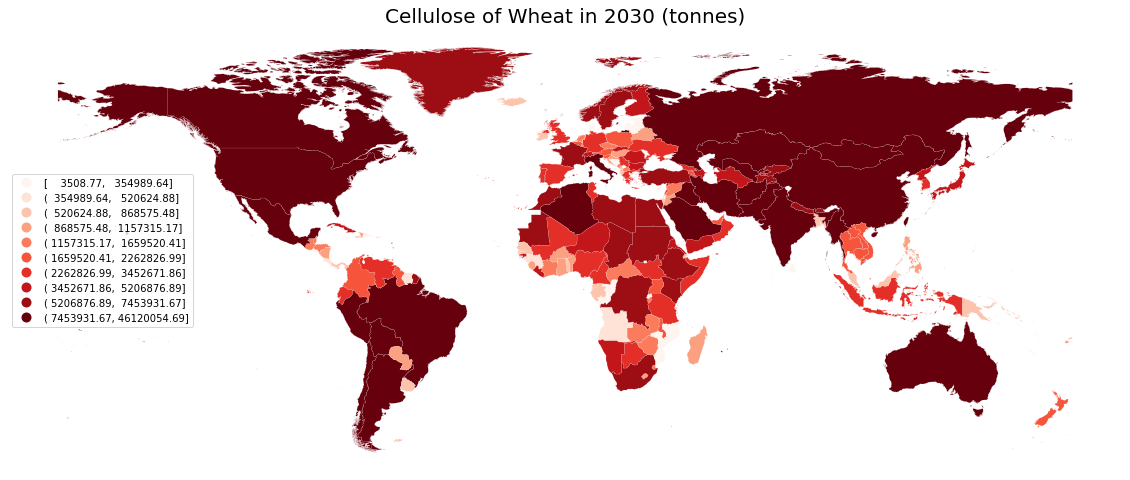

In [86]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Wheat_Cellulose_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Cellulose of Wheat in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'Lignin of Wheat in 2030 (tonnes)')

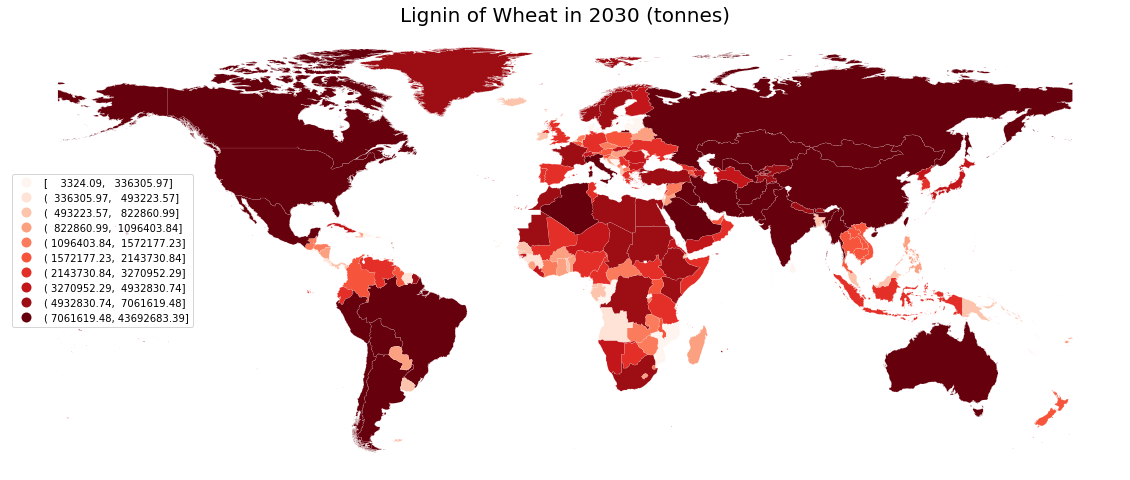

In [87]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Wheat_Lignin_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Lignin of Wheat in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'Lignin of Wheat in 2040 (tonnes)')

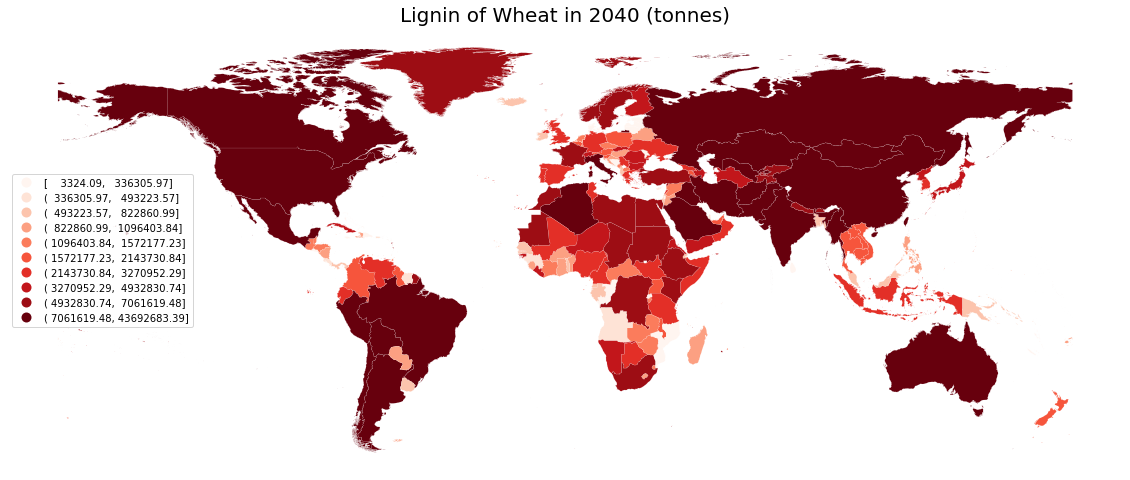

In [89]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Wheat_Lignin_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Lignin of Wheat in 2040 (tonnes)", fontsize=20)

Text(0.5, 1, 'Hemicellulose of Wheat in 2030 (tonnes)')

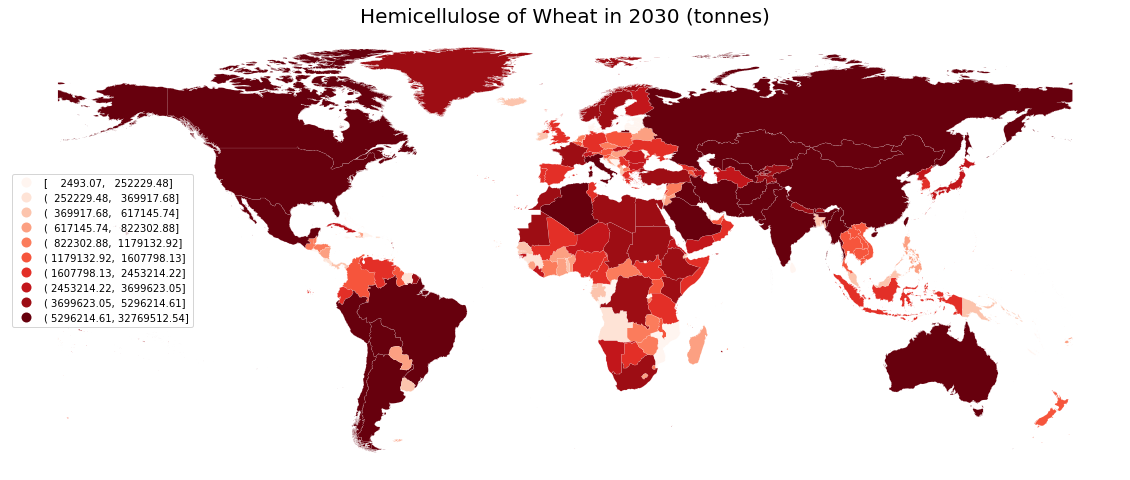

In [90]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Wheat_Hemicellulose_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Hemicellulose of Wheat in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'Hemicellulose of Wheat in 2040 (tonnes)')

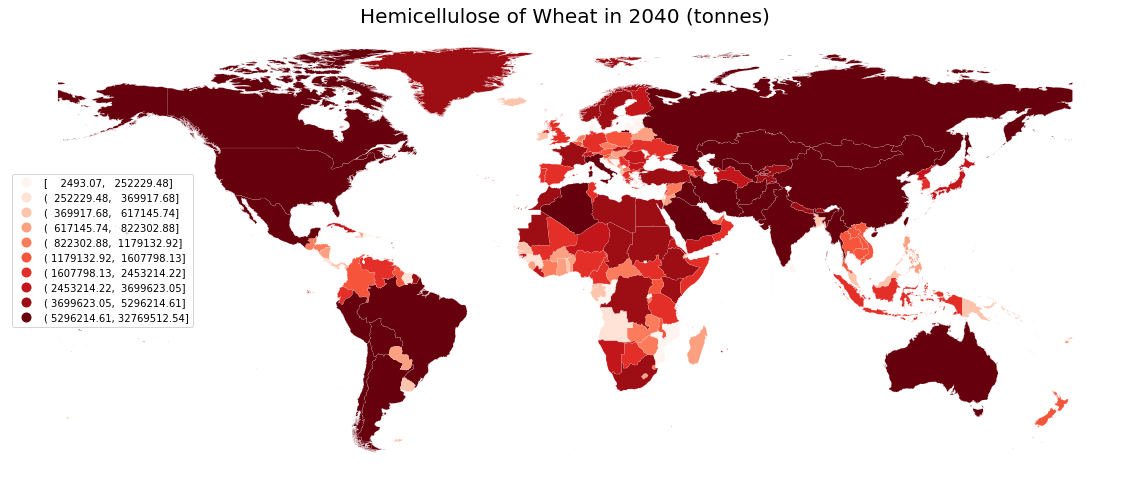

In [91]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Wheat_Hemicellulose_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Hemicellulose of Wheat in 2040 (tonnes)", fontsize=20)

Text(0.5, 1, 'Cellulose of Sorghum in 2030 (tonnes)')

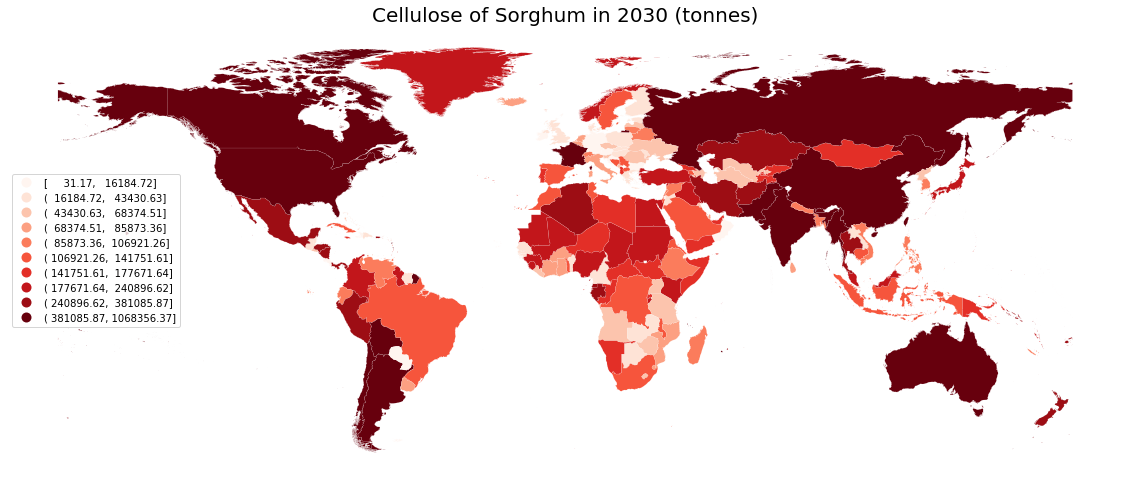

In [92]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Sorghum_Cellulose_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Cellulose of Sorghum in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'Lignin of Sorghum in 2030 (tonnes)')

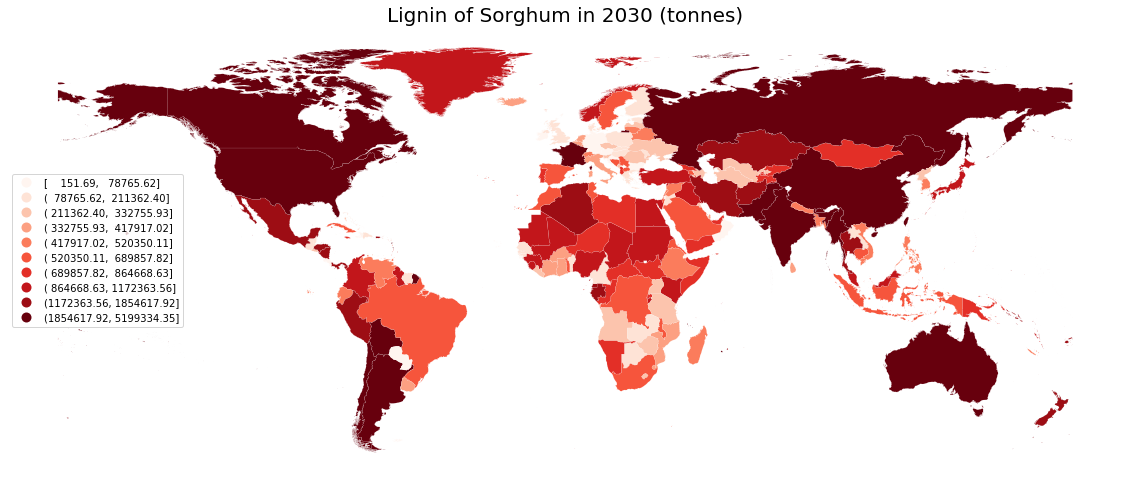

In [93]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Sorghum_Lignin_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Lignin of Sorghum in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'Lignin of Sorghum in 2040 (tonnes)')

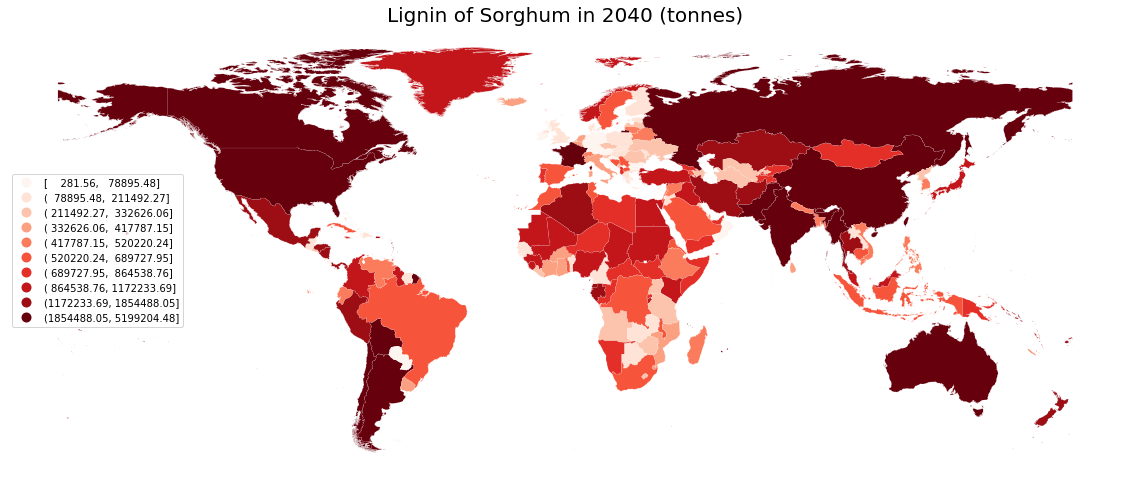

In [94]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Sorghum_Lignin_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Lignin of Sorghum in 2040 (tonnes)", fontsize=20)

Text(0.5, 1, 'Hemicellulose of Sorghum in 2030 (tonnes)')

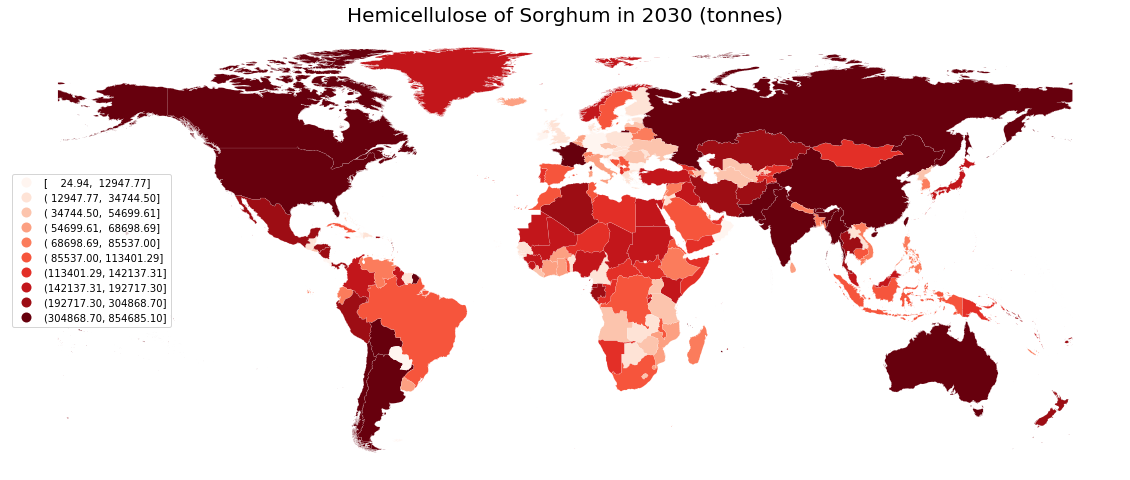

In [95]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Sorghum_Hemicellulose_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Hemicellulose of Sorghum in 2030 (tonnes)", fontsize=20)

Text(0.5, 1, 'Hemicellulose of Sorghum in 2040 (tonnes)')

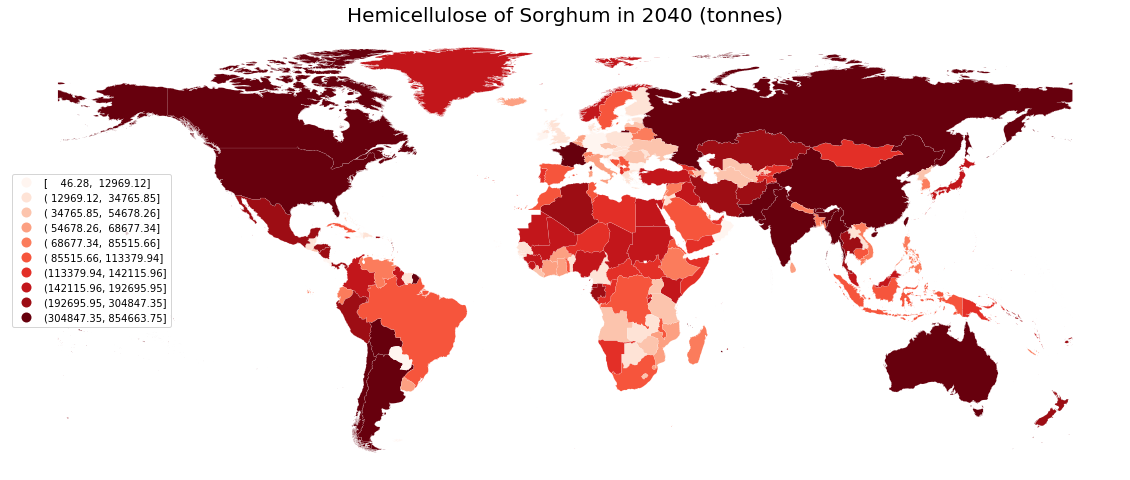

In [96]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
lignocellulose_p1.plot(column='Sorghum_Hemicellulose_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Hemicellulose of Sorghum in 2040 (tonnes)", fontsize=20)